In [1]:
%pylab inline
import numpy as np
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
r = np.arange(0, 2, 0.01)
theta = 2 * np.pi * r

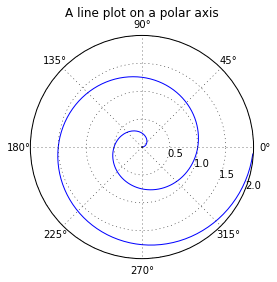

In [3]:
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')

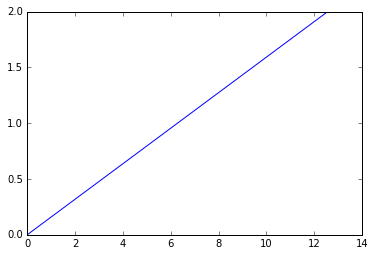

In [4]:
pl.plot(theta,r)

In [8]:
r2 = np.random.random(len(theta))

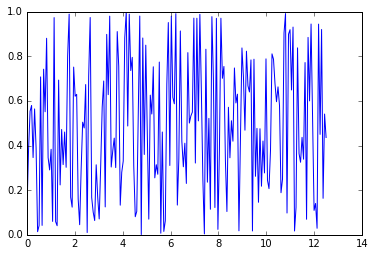

In [9]:
pl.plot(theta,r2)

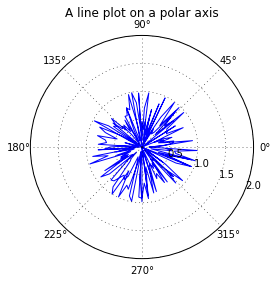

In [10]:
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r2)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')